# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

## Step 1 : Importing Libraries

In [16]:
import numpy as np
import os
from imageio import imread
import imageio.v2 as imageio
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, GlobalAveragePooling2D, GlobalAveragePooling3D, ZeroPadding3D, BatchNormalization, Activation, Dropout, ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import ConvLSTM3D, Bidirectional, LSTM, Reshape
from keras.models import Sequential

We set the random seed so that the results don't vary drastically.

In [17]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [18]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 16

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [19]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zca_whitening = True
)

def generator(source_path, folder_list, batch_size, augment=False):
    total_frames = 30
    num_images = 20
    height = 120
    width = 120
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, num_images, height, width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width))
                    
                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [20]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [22]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Plotting Accuracy and loss for both training and validation data

In [23]:
def plot_accuracy_loss(history):
    print(history.history.keys())
    # summarize accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model 1 : Using Conv3D

In [41]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, GlobalAveragePooling2D, GlobalAveragePooling3D, ZeroPadding3D, BatchNormalization, Activation, Dropout, ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
input_shape = (20, 120, 120, 3)

model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(5))
model.add(Activation('softmax'))

In [42]:
optimiser = tf.keras.optimizers.Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 20, 120, 120, 32)  2624      
                                                                 
 batch_normalization_16 (Bat  (None, 20, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                                 
 batch_normalization_17 (Bat  (None, 10, 60, 60, 64)   256       
 chNormalization)                                                
                                                      

In [43]:
model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_304/4091165505.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-3.42759-0.12500.h5
 1/42 [..............................] - ETA: 1:17 - loss: 3.4276 - categorical_accuracy: 0.1250
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-41.12017-0.15625.h5
 2/42 [>.............................] - ETA: 1:05 - loss: 41.1202 - categorical_accuracy: 0.1562
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-33.60754-0.20833.h5
 3/42 [=>............................] - ETA: 1:17 - loss: 33.6075 - categorical_accuracy: 0.2083
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-29.11999-0.21875.h5
 4/42 [=>............................] - ETA: 1:16 - loss: 29.1200 - categorical_accuracy: 0.2188
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-26.01822-0.22500.h5
 5/42 [==>...........................] - ETA: 1:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


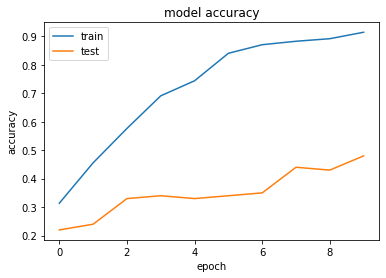

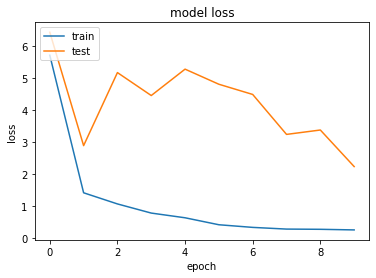

In [44]:
plot_accuracy_loss(model1)

## Model 2 : Conv3D + LSTM

In [12]:
from keras.layers import ConvLSTM3D, Bidirectional, LSTM, Reshape
from keras.models import Sequential
input_shape = (20, 120, 120, 3)

model = Sequential()

model.add(Conv3D(32, (3, 3, 3), input_shape=input_shape, activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

shape = model.layers[-1].output_shape
model.add(Reshape((shape[-1],shape[1]*shape[2]*shape[3])))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(.5))

model.add((Flatten()))

model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(5, activation='softmax'))

2023-10-09 05:43:43.568993: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-10-09 05:43:43.569086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:3f:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 118, 118, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 59, 59, 32)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 9, 59, 59, 32)    128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 7, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 3, 28, 28, 64)    0         
 3D)                                                             
                                                        

In [14]:
model_name = 'model_init_conv3d_lstm' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5' #-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]



Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [15]:
model2=model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/10


2023-10-09 05:46:42.645661: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302



Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-1.62017-0.12500.h5
 1/42 [..............................] - ETA: 3:55 - loss: 1.6202 - categorical_accuracy: 0.1250
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-1.56060-0.18750.h5
 2/42 [>.............................] - ETA: 42s - loss: 1.5606 - categorical_accuracy: 0.1875 
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-1.57368-0.22917.h5
 3/42 [=>............................] - ETA: 1:35 - loss: 1.5737 - categorical_accuracy: 0.2292
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-1.58715-0.25000.h5
 4/42 [=>............................] - ETA: 1:52 - loss: 1.5871 - categorical_accuracy: 0.2500
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-1.61531-0.26250.h5
 5/42 [==>...........................] - ETA: 1:53 - loss: 1.6153 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


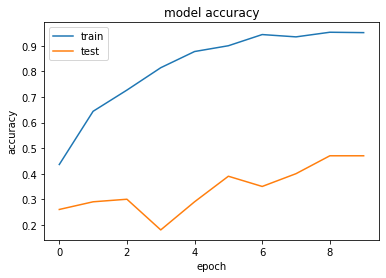

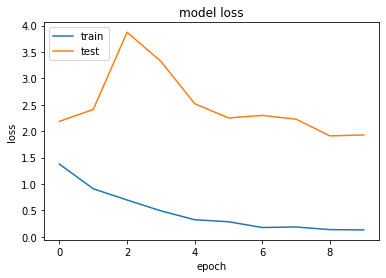

In [16]:
plot_accuracy_loss(model2)

## Model 3 : Conv3D 4 layers

In [17]:
model = Sequential()

model.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
 
model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
model.add(Conv3D(64, (3, 3, 3), padding='same'))    
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5))
model.add(Activation('softmax'))

In [19]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 20, 120, 120, 8)   656       
                                                                 
 activation (Activation)     (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_3 (Batc  (None, 20, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 60, 60, 16)    3472      
                                                                 
 activation_1 (Activation)   (None, 10, 60, 60, 16)   

In [20]:
model3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_304/385093355.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.39114-0.37500.h5
 1/42 [..............................] - ETA: 1:10 - loss: 2.3911 - categorical_accuracy: 0.3750
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.72648-0.25000.h5
 2/42 [>.............................] - ETA: 1:03 - loss: 2.7265 - categorical_accuracy: 0.2500
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.51350-0.25000.h5
 3/42 [=>............................] - ETA: 1:04 - loss: 2.5135 - categorical_accuracy: 0.2500
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.35679-0.26562.h5
 4/42 [=>............................] - ETA: 1:12 - loss: 2.3568 - categorical_accuracy: 0.2656
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.33664-0.27500.h5
 5/42 [==>...........................] - ETA: 1:12 - lo

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


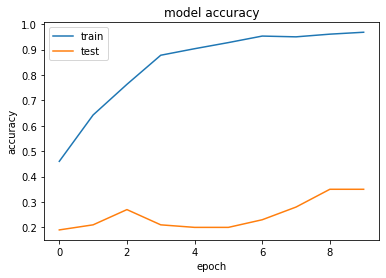

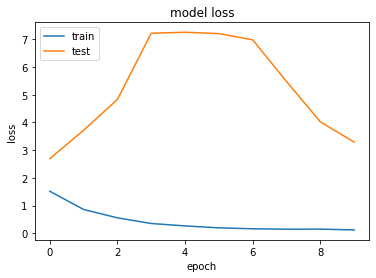

In [36]:
plot_accuracy_loss(model3)

## Model 4 : Transfer Learning

In [37]:
from keras.applications import mobilenet
from keras.layers.convolutional import Conv2D, MaxPooling2D
def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))
    # Fine-tune layers
    if (fine_tune):
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(5, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

In [38]:
num_epochs = 10 
print ('# epochs =', num_epochs)
batch_size = 10
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 10
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_22 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_24 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_25 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
    

In [39]:
model4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_304/2601353850.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.56499-0.12500.h5
 1/42 [..............................] - ETA: 3:24 - loss: 2.5650 - categorical_accuracy: 0.1250
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.19512-0.18750.h5
 2/42 [>.............................] - ETA: 1:34 - loss: 2.1951 - categorical_accuracy: 0.1875
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.10580-0.20833.h5
 3/42 [=>............................] - ETA: 1:26 - loss: 2.1058 - categorical_accuracy: 0.2083
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.03495-0.18750.h5
 4/42 [=>............................] - ETA: 1:26 - loss: 2.0349 - categorical_accuracy: 0.1875
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-1.92284-0.21250.h5
 5/42 [==>...........................] - ETA: 1:21 - lo

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


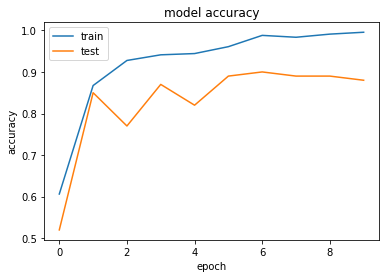

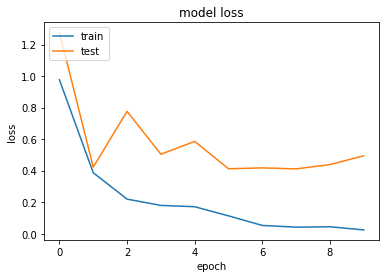

In [45]:
plot_accuracy_loss(model4)

## Model 5 : Conv2D + GRU

In [46]:
input_shape = (20, 120, 120, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam() #lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 20, 118, 118, 32)  896      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 59, 59, 32)   0         
 stributed)                                                      
                                                                 
 batch_normalization_19 (Bat  (None, 20, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_28 (TimeDi  (None, 20, 57, 57, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 20, 28, 28, 64) 

In [47]:
model5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_304/272503756.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.50825-0.18750.h5
 1/42 [..............................] - ETA: 1:37 - loss: 2.5083 - categorical_accuracy: 0.1875
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.18286-0.21875.h5
 2/42 [>.............................] - ETA: 53s - loss: 2.1829 - categorical_accuracy: 0.2188 
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.06624-0.22917.h5
 3/42 [=>............................] - ETA: 1:00 - loss: 2.0662 - categorical_accuracy: 0.2292
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-2.06563-0.23438.h5
 4/42 [=>............................] - ETA: 1:10 - loss: 2.0656 - categorical_accuracy: 0.2344
Epoch 00001: saving model to model_init_conv3d_lstm_2023-10-0905_41_50.936453/model-00001-1.83182-0.32500.h5
 5/42 [==>...........................] - ETA: 1:11 - lo

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


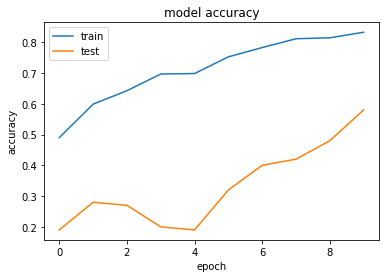

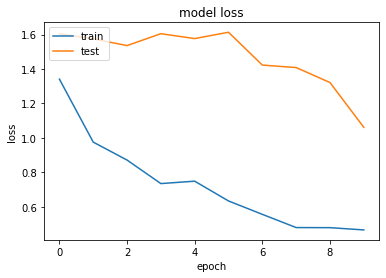

In [48]:
plot_accuracy_loss(model5)

## Model 6 : Conv2D + GlobalAveragePooling

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, GlobalAveragePooling2D, GlobalAveragePooling3D, ZeroPadding3D, BatchNormalization, Activation, Dropout, ConvLSTM2D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
input_shape = (20, 120, 120, 3)
model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model.add(BatchNormalization())

model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model.add(BatchNormalization())

model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = tf.keras.optimizers.Adam()#lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 118, 118, 8)  224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 20, 118, 118, 8)  32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 20, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)      

In [24]:
model_name = 'model_init_conv3d_global' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5' #-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [25]:
model6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


/tmp/ipykernel_306/1351847756.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/10


2023-10-11 08:08:28.907103: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302



Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-1.68010-0.12500.h5
 1/42 [..............................] - ETA: 3:31 - loss: 1.6801 - categorical_accuracy: 0.1250
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-1.70668-0.09375.h5
 2/42 [>.............................] - ETA: 27s - loss: 1.7067 - categorical_accuracy: 0.0938 
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-1.67115-0.14583.h5
 3/42 [=>............................] - ETA: 57s - loss: 1.6711 - categorical_accuracy: 0.1458
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-1.65359-0.18750.h5
 4/42 [=>............................] - ETA: 1:05 - loss: 1.6536 - categorical_accuracy: 0.1875
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-1.64054-0.20000.h5
 5/42 [==>...........................] - ETA: 1:07 - loss

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


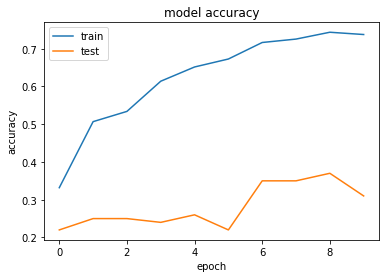

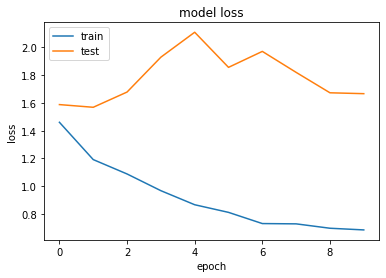

In [26]:
plot_accuracy_loss(model6)

## Model 7 : Conv3D 4 Layers with dropouts at convolutional layer

In [27]:
model = Sequential()

model.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv3D(64, (3, 3, 3), padding='same'))    
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))
    
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5))
model.add(Activation('softmax'))

In [28]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 8)   656       
                                                                 
 activation (Activation)     (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_4 (Batc  (None, 20, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 60, 60, 8)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 60, 60, 8)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 16)   

In [29]:
model7 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_306/3402876902.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model7 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-2.45561-0.25000.h5
 1/42 [..............................] - ETA: 1:15 - loss: 2.4556 - categorical_accuracy: 0.2500
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-2.56027-0.28125.h5
 2/42 [>.............................] - ETA: 1:00 - loss: 2.5603 - categorical_accuracy: 0.2812
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-2.52716-0.25000.h5
 3/42 [=>............................] - ETA: 1:03 - loss: 2.5272 - categorical_accuracy: 0.2500
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-2.56521-0.18750.h5
 4/42 [=>............................] - ETA: 1:13 - loss: 2.5652 - categorical_accuracy: 0.1875
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-2.52937-0.21250.h5
 5/42 [==>...........................] - ETA:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


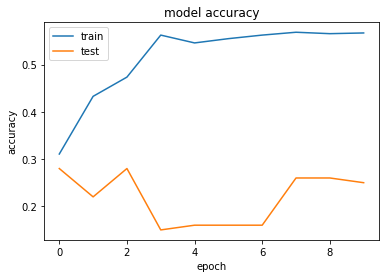

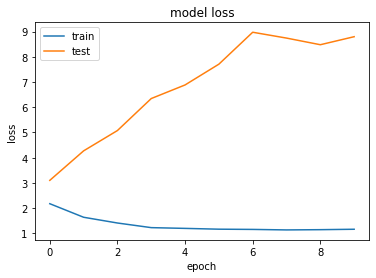

In [30]:
plot_accuracy_loss(model7)

## Model 8 : Conv3D + L2 Regularization

In [37]:
from keras.regularizers import l2
model = Sequential()

model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape = input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5))
model.add(Activation('softmax'))

In [34]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activation_8 (Activation)   (None, 10, 60, 60, 32)   

In [35]:
model8 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_306/11433973.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model8 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-3.69899-0.25000.h5
 1/42 [..............................] - ETA: 1:18 - loss: 3.6990 - categorical_accuracy: 0.2500
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-3.71244-0.21875.h5
 2/42 [>.............................] - ETA: 1:47 - loss: 3.7124 - categorical_accuracy: 0.2188
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-3.57743-0.25000.h5
 3/42 [=>............................] - ETA: 1:21 - loss: 3.5774 - categorical_accuracy: 0.2500
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-3.46849-0.25000.h5
 4/42 [=>............................] - ETA: 1:23 - loss: 3.4685 - categorical_accuracy: 0.2500
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-3.32467-0.27500.h5
 5/42 [==>...........................] - ETA:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


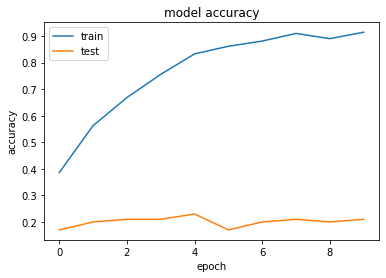

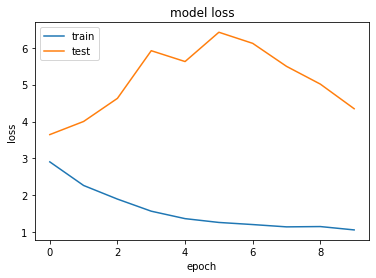

In [36]:
plot_accuracy_loss(model8)

## Model 9 : Conv3D + L2 Regularization with more convolutional layers

In [39]:
from keras.regularizers import l2
model = Sequential()

model.add(Conv3D(16, (3, 3, 3), padding='same', input_shape = input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256,activation='relu',kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5))
model.add(Activation('softmax'))

In [40]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_17 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_22 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_27 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 activation_23 (Activation)  (None, 10, 60, 60, 32)  

In [41]:
model9 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_306/2554849582.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model9 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-6.63165-0.12500.h5
 1/42 [..............................] - ETA: 56s - loss: 6.6316 - categorical_accuracy: 0.1250
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-6.17369-0.18750.h5
 2/42 [>.............................] - ETA: 1:37 - loss: 6.1737 - categorical_accuracy: 0.1875
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-6.05149-0.27083.h5
 3/42 [=>............................] - ETA: 1:35 - loss: 6.0515 - categorical_accuracy: 0.2708
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-6.05764-0.28125.h5
 4/42 [=>............................] - ETA: 1:29 - loss: 6.0576 - categorical_accuracy: 0.2812
Epoch 00001: saving model to model_init_conv3d_global_2023-10-1108_07_22.703484/model-00001-6.07865-0.28750.h5
 5/42 [==>...........................] - ETA: 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


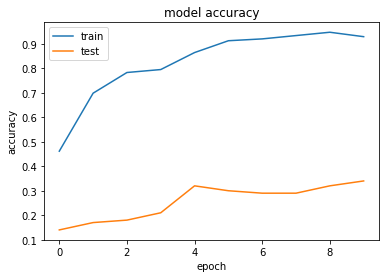

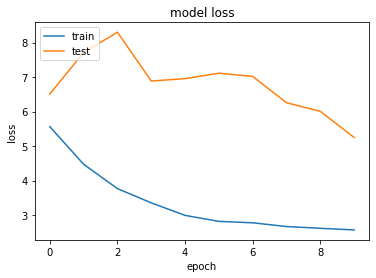

In [42]:
plot_accuracy_loss(model9)